In [1]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import imutils
from PIL import Image 
import tarfile
import pickle
import os
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve
import dlib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier as KNN
import torch
import torch.nn as nn
from sklearn.cluster import KMeans, AgglomerativeClustering
#ref https://www.kaggle.com/saidakbarp/face-recognition-part-1
#ref https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/
#ref https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/
#ref https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
#ref https://www.kaggle.com/serkanpeldek/face-detection-with-opencv


## Read in data

In [2]:
fname = r'data\lfwpeople\lfw-funneled.tgz'

def jpg_files(members): #only extract jpg files
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo
def untar(fname,path="LFW"): #untarring the file
    tar = tarfile.open(fname)
    tar.extractall(path, members = jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to",  path)
        
#unzip tgz file
untar(fname,"LFW")

File Extracted in to LFW


In [3]:
names = os.listdir('LFW\lfw_funneled')
names[0]
# totally 13244  of images read in, and 5760 prople in the data
total = sum([len(files) for r, d, files in os.walk(r'LFW/lfw_funneled')])
print(total, len(names))

13244 5760


In [4]:
def extract_image(num_fig):
    imglist = []
    #scan over the folder
    for r, d, files in os.walk('LFW\lfw_funneled'):   
        if len(files) >= num_fig: 
            imglist.append(r)
            
    Im_total = []
    labels = []
    labels2 = []
    #process each picture, extract name of the image as label
    for count, i in enumerate(imglist):
        files = os.listdir(i)
        name = imglist[count].split('\\')[2]
        for count2, j in enumerate(files):
            im = cv2.imread(i + r'/' + j)
            #b,g,r = cv2.split(im)
            #im = cv2.merge([r,g,b])
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #opencv uses RGB
            Im_total +=[im]
            labels += [name]
            labels2 += [name+str(count2+1)] #keep indexes of each person for later usage
    return (Im_total, labels, labels2)

In [37]:
# only read in images for the person who have more than 20 pictures
(Im_set, label, label2) =  extract_image(20) 

In [9]:
len(Im_set), len(label), len(label2)

(3023, 3023, 3023)

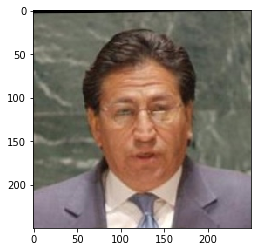

In [6]:
plt.imshow(Im_set[0])

## Face Alignment

#### Weird Face deleted

In [38]:
# function to return the box of faces detected by dlib
def face_marks_box(img, detector, predictor):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)    
    if len(rects) > 0:
        for rect in rects:
            #get box of face
            x = rect.left()
            y = rect.top()
            w = rect.right()
            h = rect.bottom()
            #get face landmarks
            shape0 = predictor(gray, rect)
        shape_normal = []
        for i in range(0,5):
            shape_normal += [[shape0.part(i).x, shape0.part(i).y]]
        return x, y, w, h, shape_normal
    x = None
    y = None
    w = None
    h = None
    shape_normal = None
    return x, y, w, h, shape_normal

# function to return positons/coordinates of face landmarks
def calculate_features(shape_normal, x, w, y):
    #get each features
    right_eye = (np.array(shape_normal[0]) + np.array(shape_normal[1]))//2
    left_eye = (np.array(shape_normal[2]) + np.array(shape_normal[3]))//2
    nose = np.array(shape_normal[4])
    
    #calculate centers of eyes and topline of the box
    center_top_rec = np.array([int((x+w)/2), y])
    center_head = (left_eye + right_eye)//2
    
    return right_eye, left_eye, nose, center_top_rec, center_head

# function to calculate the rotate angle for face alignment
def calculate_angle(nose, center_head, center_top_rec):
    #calculate triangle distances
    #3
    head_to_top = np.linalg.norm(center_top_rec - center_head)
    #1
    nose_to_head = np.linalg.norm(nose - center_head)
    #2
    nose_to_top = np.linalg.norm(center_top_rec - nose)
    
    #calculate angle to be rotate
    cosA = (nose_to_head**2 + nose_to_top**2 - head_to_top**2)/(2*nose_to_head*nose_to_top)
    if cosA > 1 or cosA < -1:
        cosA = int(cosA)
    angle = np.arccos(cosA)
    
    #test if rotate head point is on the line from nose to topline box
    #if the rotate point on the nose_to_box vector origin from nose, 
    #angle is positive ie rotate counter clockwise
    trans_p = center_head - nose
    s = np.sin(angle)
    c = np.cos(angle)
    Rotate_matrix = np.array([[c, -s], [s, c]])
    rotated_trans = Rotate_matrix @ trans_p
    #rotated_trans_p = np.int32(rotated_trans + nose)
    #decide if on the line using dot product, ie check if ab = |a||b|
    target_vector = center_top_rec - nose
    dot = np.dot(target_vector, rotated_trans)
    length = np.linalg.norm(target_vector) * np.linalg.norm(rotated_trans)

    #print(int(dot*10**6), int(length*10**6))
    if int(dot*10**6) == int(length*10**6):
        angle = np.degrees(-angle)
    else:
        angle = np.degrees(angle)
                
    return angle

#function to perform face alignment
def face_alignment(Img_set):
    #using models from dlib
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    Out_img = []
    Delete_set = []
    for j, i in enumerate(Img_set):
        x, y, w, h, shape_normal = face_marks_box(i, detector, predictor)
        if x is None:
            #print(j, 'No face detected!')
            #Out_img += [i]
            #record image need to be deleted, since no face detected
            Delete_set += [j]
            continue
        right_eye, left_eye, nose, center_top_rec, center_head = calculate_features(shape_normal, x, w, y)
        angle = calculate_angle(nose, center_head, center_top_rec)
        output = i + 0
        output = Image.fromarray(output)
        output = np.array(output.rotate(angle))
        Out_img += [output]
    return Out_img, Delete_set

#function to plot face landmarks with those points used to calculate rorate angle
def plot_landmark(image, detector, predictor):
    img = image + 0

    x, y, w, h, shape_normal = face_marks_box(img, detector, predictor)
    right_eye, left_eye, nose, center_top_rec, center_head = calculate_features(shape_normal, x, w, y)
    
    #right
    cv2.circle(img, tuple(right_eye), 1, (0, 0, 255), 2)
    #left
    cv2.circle(img, tuple(left_eye), 1, (0, 0, 255), 2)
    #nose
    cv2.circle(img, tuple(nose), 1, (0, 0, 255), 2)

    ## center head 
    cv2.circle(img, tuple(center_head), 1, (0, 0, 255), 2)

    ## center top 
    cv2.circle(img, tuple(center_top_rec), 1, (0, 0, 255), 2)

    #top line
    #cv2.circle(img, (x, y), 1, (0, 255, 0), 2)
    #cv2.circle(img, (w, y), 1, (0, 255, 0), 2)
    
    cv2.rectangle(img, (x, y), (w, h), (0, 255, 0), 1)
    
    #triangle
    cv2.line(img, tuple(nose), tuple(center_head), (255, 0, 0), 1) 
    cv2.line(img, tuple(nose), tuple(center_top_rec), (255, 0, 0), 1) 
    cv2.line(img, tuple(center_top_rec), tuple(center_head), (255, 0, 0), 1) 
    
    #calculate triangle distances
    #3
    head_to_top = np.linalg.norm(center_top_rec - center_head)
    #1
    nose_to_head = np.linalg.norm(nose - center_head)
    #2
    nose_to_top = np.linalg.norm(center_top_rec - nose)
    
    #calculate angle to be rotate
    cosA = (nose_to_head**2 + nose_to_top**2 - head_to_top**2)/(2*nose_to_head*nose_to_top)
    angle = np.arccos(cosA)
    
    #calculate rotated point to check
    trans_p = center_head - nose
    s = np.sin(angle)
    c = np.cos(angle)
    Rotate_matrix = np.array([[c, -s], [s, c]])
    rotated_trans = Rotate_matrix @ trans_p
    rotated_trans_p = np.int32(rotated_trans + nose)
    
    cv2.circle(img, tuple(rotated_trans_p), 1, (255, 0, 0), 2)
    
    
    plt.imshow(img)

In [12]:
#using dlib function to detect if the image has a face
detector = dlib.get_frontal_face_detector()
#using the pretrained model from dlib to detect 5 face landmarks (left eye edges, right eye edges, nose)
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

In [57]:
aligned_set, deleted_index = face_alignment(Im_set)

In [58]:
#some images deleted, different number of images and labels
len(aligned_set), len(deleted_index), len(label), len(label2)

(2996, 27, 2996, 2996)

In [41]:
#correct the number of labels according to the records
for count, i in enumerate(deleted_index):
    del label[i-count]
    del label2[i-count]

In [42]:
#numbers of labels corrected
len(aligned_set), len(deleted_index), len(label), len(label2)

(2996, 27, 2996, 2996)

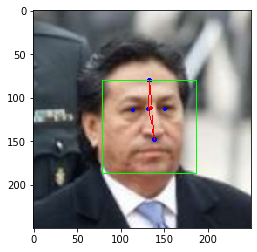

In [71]:
#plot to see the original face for checking if aligned in next figure
plot_landmark(Im_set[19], detector, predictor)

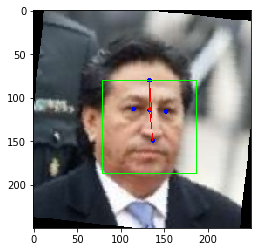

In [70]:
#plot of aligned face
plot_landmark(aligned_set[19], detector, predictor)

## Cropped Faces

In [72]:
#function to return the box of detected face
def detect_face_box(img):
    modelFile ="res10_300x300_ssd_iter_140000.caffemodel"
    configFile = "deploy.prototxt.txt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    h,w = img.shape[:2]
    #resize and centering the image bfore feeding into the model
    #model requires 300*300 image
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    #print("[INFO] computing object detections...")
    net.setInput(blob)
    #feed forward for prediction
    detections = net.forward()
    CON = detections[0, 0, :, 2] #all confidence values
    #get box coordnates, only consider 1 face thus using the max of confidence/score of the box
    box = detections[0, 0, np.where(np.max(CON)), 3:7] * np.array([w, h, w, h])
    startX, startY, endX, endY = box.astype("int")[0][0]
    return (startX, startY, endX, endY, np.max(CON))
    
#function to plot the box that detected face
def plot_box(img, startX, startY, endX, endY, confidence):
    text = "{:.2f}%".format(confidence * 100)
    #test if y touches the edge
    y = startY - 10 if startY - 10 > 10 else startY + 10
    #draw box and confidence on the image
    img1 = img + 0
    cv2.rectangle(img1, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(img1, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    plt.imshow(img1)

#function ot cropped the face region according to the box
def cropped_face(img, startX, startY, endX, endY):
    orig = Image.fromarray(img+0)
    trans = orig.crop((startX, startY, endX, endY))
    return np.array(trans)

#function implement face cropping
def detect_crop(img):
    startX, startY, endX, endY, _ = detect_face_box(img)
    #cropped = cropped_face(im, startX, startY, endX, endY)
    cropped = img[startY:endY, startX:endX, :]
    return cropped

In [73]:
#implement the function to crop the face
Crop_set = []
for index, i in enumerate(aligned_set):
    Crop_set += [detect_crop(i)]

In [74]:
#check size
len(Crop_set), len(label), len(label2)

(2996, 2996, 2996)

In [75]:
#save all images and labels for later usage
f = open(os.getcwd()+r'\data\data_cropped', "wb")
f2 = open(os.getcwd()+r'\data\data_cropped_labels', "wb")
f3 = open(os.getcwd()+r'\data\data_cropped_labels2', "wb")
f.write(pickle.dumps(Crop_set))
f2.write(pickle.dumps(label))
f3.write(pickle.dumps(label2))
f.close()
f2.close()
f3.close()

## Embedding

In [76]:
cropped = pickle.loads(open(os.getcwd()+r'\data\data_cropped', "rb").read())
cropped_label = pickle.loads(open(os.getcwd()+r'\data\data_cropped_labels', "rb").read())
cropped_label2 = pickle.loads(open(os.getcwd()+r'\data\data_cropped_labels2', "rb").read())
len(cropped), len(cropped_label), len(cropped_label2)

(2996, 2996, 2996)

In [77]:
#make sure size of cropped face is large enough
#some have size 0, delete
remove_list = []
for i in range(len(cropped)):
    f_h, f_w = cropped[i].shape[:2]
    if f_h < 20 or f_w < 20:
        remove_list += [i]
remove_list

[2662]

In [78]:
for count, i in enumerate(remove_list):
    del cropped[i-count]
    del cropped_label[i-count]
    del cropped_label2[i-count]
len(cropped), len(cropped_label), len(cropped_label2)

(2995, 2995, 2995)

## Embedding

In [80]:
#read in embedder model to produce 128-D array for each image
emedderFile = 'openface_nn4.small2.v1.t7'
embedder = cv2.dnn.readNetFromTorch(emedderFile)

In [82]:
#Perform embbeding to extract features of image
#retrun 128D vectors for each input image
Embedded = []
for i in range(len(cropped)):
    #blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
    #nomoralize the image ie mean subtraction, scale by var, etc.
    face = cropped[i]
    faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
    embedder.setInput(faceBlob)
    vector_128 = embedder.forward().flatten()
    vector_128.shape
    Embedded += [vector_128]
len(Embedded)

2995

## Preprocessing with train and test

In [125]:
X = np.array(Embedded)
y = np.array(cropped_label)

encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y) #encoded lables into numbers

In [86]:
X.shape, y_encoded.shape

((2995, 128), (2995,))

In [87]:
#split train, test data
X_tr, X_te, y_tr, y_te = train_test_split(X, y_encoded, test_size = 0.2,random_state = 42)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((2396, 128), (599, 128), (2396,), (599,))

## Classification - SVM

In [90]:
import warnings
warnings.filterwarnings("ignore")

In [131]:
#Tuning parameters for SVM

Result = []
for i in ['linear', 'rbf', 'sigmoid']:
    for c in np.linspace(145, 160, num = 10):
        model = SVC(kernel = i, C = c, gamma = 'auto')
        accuracy = np.mean(cross_val_score(model, X_tr, y_tr, cv = 5))

        model.fit(X_tr, y_tr)
        pre = model.predict(X_tr)
        accuracy_train = sum(pre == y_tr)/len(y_tr)
        
        pre2 = model.predict(X_te)
        accuracy_test = sum(pre2 == y_te)/len(y_te)
        
        Matrix = confusion_matrix(y_tr, pre)
        index = np.argmax(np.diag(Matrix))
        max_correct = np.logical_and(pre == range(62)[index], y_tr == range(62)[index]).sum() 
        Result += [(i, c ,accuracy)]
        print('{} kernel C = {} CV Acc {}, Train ACC {}, Test Acc {}, Max correct for 1 person {}\n'.
              format(i, c, round(accuracy, 3), round(accuracy_train,3), round(accuracy_test,3), max_correct))

linear kernel C = 145.0 CV Acc 0.541, Train ACC 0.966, Test Acc 0.558, Max correct for 1 person 405

linear kernel C = 146.66666666666666 CV Acc 0.542, Train ACC 0.966, Test Acc 0.556, Max correct for 1 person 405

linear kernel C = 148.33333333333334 CV Acc 0.542, Train ACC 0.966, Test Acc 0.558, Max correct for 1 person 405

linear kernel C = 150.0 CV Acc 0.542, Train ACC 0.966, Test Acc 0.556, Max correct for 1 person 405

linear kernel C = 151.66666666666666 CV Acc 0.542, Train ACC 0.966, Test Acc 0.556, Max correct for 1 person 405

linear kernel C = 153.33333333333334 CV Acc 0.542, Train ACC 0.967, Test Acc 0.558, Max correct for 1 person 405

linear kernel C = 155.0 CV Acc 0.542, Train ACC 0.967, Test Acc 0.558, Max correct for 1 person 405

linear kernel C = 156.66666666666666 CV Acc 0.542, Train ACC 0.967, Test Acc 0.558, Max correct for 1 person 405

linear kernel C = 158.33333333333334 CV Acc 0.541, Train ACC 0.967, Test Acc 0.558, Max correct for 1 person 405

linear kernel

In [132]:
#best with C = , kernel = 'linear'
SVM_final = SVC(kernel = 'linear', C = 155)
SVM_final.fit(X, y_encoded)
SVM_fit = SVM_final.predict(X)
accuracy_score(SVM_fit, y_encoded)

0.9515859766277128

## Classification - Random Forest

In [100]:
test_n_estimators = np.array(range(100, 120))
criterion_ = ["gini", "entropy"]
features = ['auto', 'sqrt', 'log2']

for i in criterion_:
    for n_tree in test_n_estimators:
        for num_feature in features:
            rf = RandomForestClassifier(n_estimators = n_tree, 
                                        criterion = i, 
                                        max_features = num_feature)
            cv_score = np.mean(cross_val_score(rf, X_tr, y_tr, cv = 5))
            rf.fit(X_tr, y_tr)
            fit_inside = rf.predict(X_tr)
            pre_inside = rf.predict(X_te)
            
            
            accuracy_train = sum(fit_inside == y_tr)/len(y_tr)
            accuracy_test = sum(pre_inside == y_te)/len(y_te)
            print('{} num trees {} max num features, cv acc {}, train acc {}, test acc {}'.
                  format(n_tree, num_feature, round(cv_score,3), round(accuracy_train,3), round(accuracy_test, 3)))

100 num trees auto max num features, cv acc 0.431, train acc 1.0, test acc 0.444
100 num trees sqrt max num features, cv acc 0.433, train acc 1.0, test acc 0.426
100 num trees log2 max num features, cv acc 0.422, train acc 1.0, test acc 0.421
101 num trees auto max num features, cv acc 0.437, train acc 1.0, test acc 0.434
101 num trees sqrt max num features, cv acc 0.424, train acc 1.0, test acc 0.421
101 num trees log2 max num features, cv acc 0.419, train acc 1.0, test acc 0.441
102 num trees auto max num features, cv acc 0.433, train acc 1.0, test acc 0.414
102 num trees sqrt max num features, cv acc 0.425, train acc 1.0, test acc 0.432
102 num trees log2 max num features, cv acc 0.423, train acc 1.0, test acc 0.434
103 num trees auto max num features, cv acc 0.425, train acc 1.0, test acc 0.427
103 num trees sqrt max num features, cv acc 0.43, train acc 1.0, test acc 0.432
103 num trees log2 max num features, cv acc 0.427, train acc 1.0, test acc 0.429
104 num trees auto max num fe

114 num trees auto max num features, cv acc 0.428, train acc 1.0, test acc 0.431
114 num trees sqrt max num features, cv acc 0.436, train acc 1.0, test acc 0.441
114 num trees log2 max num features, cv acc 0.424, train acc 1.0, test acc 0.434
115 num trees auto max num features, cv acc 0.437, train acc 1.0, test acc 0.442
115 num trees sqrt max num features, cv acc 0.432, train acc 1.0, test acc 0.424
115 num trees log2 max num features, cv acc 0.424, train acc 1.0, test acc 0.446
116 num trees auto max num features, cv acc 0.438, train acc 1.0, test acc 0.436
116 num trees sqrt max num features, cv acc 0.432, train acc 1.0, test acc 0.437
116 num trees log2 max num features, cv acc 0.432, train acc 1.0, test acc 0.422
117 num trees auto max num features, cv acc 0.435, train acc 1.0, test acc 0.426
117 num trees sqrt max num features, cv acc 0.432, train acc 1.0, test acc 0.427
117 num trees log2 max num features, cv acc 0.427, train acc 1.0, test acc 0.419
118 num trees auto max num f

In [127]:
X.shape, y_encoded.shape

((2995, 128), (2995,))

In [128]:
RF_final = RandomForestClassifier(n_estimators = 100, max_features = 'auto')
RF_final.fit(X, y_encoded)
RF_fit = RF_final.predict(X)
accuracy_score(RF_fit, y_encoded)

1.0

## KNN

In [103]:
for i in range(1, 30):
    model = KNN(n_neighbors = i, p = 2)
    accuracy_cv = np.mean(cross_val_score(model, X_tr, y_tr, cv = 5))
    model.fit(X_tr, y_tr)
    y_f = model.predict(X_tr)
    y_p = model.predict(X_te)

    accuracy = sum(y_f == y_tr)/len(y_tr)
    accuracy2 = sum(y_p == y_te)/len(y_te)
    Matrix = confusion_matrix(y_tr, y_f)
    index = np.argmax(np.diag(Matrix))
    max_correct = np.logical_and(y_f == range(62)[index], 
                                 np.array(y_tr) == range(62)[index]).sum() 
    print((i, accuracy_cv, accuracy, accuracy2, max_correct))

(1, 0.3923277661795407, 1.0, 0.3739565943238731, 425)
(2, 0.38188152400835074, 0.6990818030050083, 0.3572621035058431, 377)
(3, 0.4010864648573417, 0.6535893155258765, 0.3756260434056761, 370)
(4, 0.4115205288796103, 0.6348080133555927, 0.4073455759599332, 372)
(5, 0.4261273486430063, 0.6310517529215359, 0.41569282136894825, 378)
(6, 0.43322546972860126, 0.6122704507512521, 0.4273789649415693, 379)
(7, 0.43739909533750876, 0.6051752921535893, 0.4290484140233723, 381)
(8, 0.43739561586638837, 0.593906510851419, 0.4373956594323873, 384)
(9, 0.43822894919972166, 0.5784641068447413, 0.4240400667779633, 386)
(10, 0.43948155880306194, 0.5621869782971619, 0.42237061769616024, 384)
(11, 0.43865170494084893, 0.5550918196994992, 0.42237061769616024, 381)
(12, 0.43990170494084896, 0.5450751252086812, 0.42070116861435725, 374)
(13, 0.43990083507306893, 0.5354757929883138, 0.41736227045075125, 375)
(14, 0.4394850382741823, 0.5317195325542571, 0.4240400667779633, 377)
(15, 0.43906663187195544, 0.524

In [133]:
KNN_final = KNN(n_neighbors = 8, p = 2)
KNN_final.fit(X, y_encoded)
RF_fit = RF_final.predict(X)
accuracy_score(RF_fit, y_encoded)

1.0

## NN

In [116]:
train_loader = torch.utils.data.DataLoader(dataset = np.concatenate((X_tr, y_tr.reshape(len(y_tr),1)), axis = 1), 
                                           batch_size = 500, 
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = np.concatenate((X_te, y_te.reshape(len(y_te),1)), axis = 1), 
                                           batch_size = 500, 
                                           shuffle = True)

In [117]:
class deep_n(nn.Module):
    def __init__(self, num_layer, combination, comb_norm, input_size, 
                 hidden_size, hidden_size2, hidden_size3, output_size):
        super(deep_n, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_size)       
        self.fc2 = nn.Linear(hidden_size, hidden_size2)      
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) 
        self.fc4 = nn.Linear(hidden_size3, output_size)
        
        self.ac1 = nn.ReLU()
        self.ac2 = nn.Sigmoid()
        self.ac3 = nn.Tanh()
        
        self.norm = nn.BatchNorm1d(num_features = hidden_size)
        self.norm2 = nn.BatchNorm1d(num_features = hidden_size2)
        self.norm3 = nn.BatchNorm1d(num_features = hidden_size3)
        self.lastac = nn.Softmax(dim = 1)
        
        self.layer = num_layer
        self.combination = combination
        self.norm_index = comb_norm
    
    def forward(self, x):
        #out = self.fc1(x)
        for l in range(self.layer-1):
            if l+1 == 1:
                out = self.fc1(x) #128 -> hidden1
            elif l+1 == 4:
                out = self.fc2(out) #hidden1 -> hidden2
            elif l+1 == 7:
                out = self.fc3(out) #hidden2 -> hidden3
            
            if self.combination[l] == 1:
                out = self.ac1(out)
            elif self.combination[l] == 2:
                out = self.ac2(out)
            elif self.combination[l] == 3:
                out = self.ac3(out)
                
                
            if self.norm_index[l]:
                if l+1 < 4:
                    out = self.norm(out)
                elif l+1 >= 4 and l+1 < 7:
                    out = self.norm2(out)
                elif l+1 >= 7:
                    out = self.norm3(out)
        out = self.fc4(out)
        out = self.lastac(out)
        return out

In [119]:
num_layer = 10
num_activation = 2
learning_rate = 0.0001
epoches = 200

Order_act = []
Model_list = []
for t in range(10):
    index_activation = np.random.choice(num_activation, num_layer)+1
    #index_activation = np.ones(num_layer)+1
    #index_activation[9] = 1
    #index_norm = np.random.choice(2, num_layer)
    index_norm = np.ones(num_layer)
    Order_act += [np.vstack((index_activation, index_norm))]


    model = deep_n(num_layer = num_layer, combination = index_activation, comb_norm = index_norm, input_size = 128, 
                   hidden_size = 500, hidden_size2 = 400, hidden_size3 = 300, output_size = len(np.unique(y_tr)))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

    list_act = ['ReLU', 'Sigmoid']
    choice_act = [list_act[int(index_activation[i]-1)] for i in range(num_layer)]
    #print('activation function {} \nnorm index {}'.format(choice_act, index_norm))
    print(choice_act)
    for ep in range(epoches+1):
        for j, i in enumerate(train_loader):
            X = i[:, :128].requires_grad_()
            y = i[:, 128]
            optimizer.zero_grad()
            output = model.forward(X.float())
            loss = criterion(output, y.long())
            loss.backward()
            optimizer.step()
            
            _, predict2 = torch.max(output.data, 1)
            #print(predict2)

        if ep % 10 == 0:
            correct = 0
            total = 0
            for j, i in enumerate(test_loader):
                X = i[:, :128]
                y = i[:, 128]
                output = model.forward(X.float())
                _, predict = torch.max(output.data, 1)
                correct += sum(predict == y)
                total += y.shape[0]
            acc = correct.numpy() / total

            correct = 0
            total = 0
            for j, i in enumerate(test_loader):
                X = i[:, :128]
                y = i[:, 128]
                output = model.forward(X.float())
                _, predict = torch.max(output.data, 1)
                correct += sum(predict == y)
                total += y.shape[0]
            acc2 = correct.numpy() / total
            print('ep {} loss {}, train accuracy {}, test accuracy {}'.format(ep, loss.item(), acc, acc2))
    
    Model_list += [model]
    #print('t {} {}\nep {} loss {}, train accuracy {}, test accuracy {}'.format(t+1, choice_act,
    #                                                                           ep, loss.item(), acc, acc2))
    

['Sigmoid', 'ReLU', 'ReLU', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'ReLU', 'Sigmoid', 'Sigmoid', 'ReLU']
ep 0 loss 4.11618185043335, train accuracy 0.12186978297161936, test accuracy 0.1285475792988314
ep 10 loss 3.852846145629883, train accuracy 0.34390651085141904, test accuracy 0.33889816360601
ep 20 loss 3.7407398223876953, train accuracy 0.4006677796327212, test accuracy 0.4056761268781302
ep 30 loss 3.6216399669647217, train accuracy 0.4240400667779633, test accuracy 0.4273789649415693
ep 40 loss 3.5861029624938965, train accuracy 0.4707846410684474, test accuracy 0.4691151919866444
ep 50 loss 3.4879000186920166, train accuracy 0.48247078464106846, test accuracy 0.48747913188647746
ep 60 loss 3.4474401473999023, train accuracy 0.5008347245409015, test accuracy 0.49081803005008345
ep 70 loss 3.4249160289764404, train accuracy 0.5108514190317195, test accuracy 0.5091819699499165
ep 80 loss 3.347104072570801, train accuracy 0.5208681135225376, test accuracy 0.5125208681135225
ep 90 loss 3

ep 160 loss 3.167030096054077, train accuracy 0.5459098497495827, test accuracy 0.5459098497495827
ep 170 loss 3.1720409393310547, train accuracy 0.5642737896494157, test accuracy 0.5559265442404007
ep 180 loss 3.165696620941162, train accuracy 0.5559265442404007, test accuracy 0.5575959933222037
ep 190 loss 3.163330316543579, train accuracy 0.5475792988313857, test accuracy 0.5542570951585977
ep 200 loss 3.1683907508850098, train accuracy 0.5509181969949917, test accuracy 0.5575959933222037
['ReLU', 'ReLU', 'ReLU', 'ReLU', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'ReLU', 'ReLU', 'Sigmoid']
ep 0 loss 4.122838020324707, train accuracy 0.048414023372287146, test accuracy 0.048414023372287146
ep 10 loss 3.9081201553344727, train accuracy 0.327212020033389, test accuracy 0.31886477462437396
ep 20 loss 3.7414562702178955, train accuracy 0.3772954924874791, test accuracy 0.3739565943238731
ep 30 loss 3.647688627243042, train accuracy 0.41903171953255425, test accuracy 0.41235392320534225
ep 40 loss 

ep 110 loss 3.1986377239227295, train accuracy 0.5542570951585977, test accuracy 0.5509181969949917
ep 120 loss 3.204826593399048, train accuracy 0.5626043405676127, test accuracy 0.5592654424040067
ep 130 loss 3.2011358737945557, train accuracy 0.5626043405676127, test accuracy 0.5676126878130217
ep 140 loss 3.198221206665039, train accuracy 0.5542570951585977, test accuracy 0.5609348914858097
ep 150 loss 3.176398754119873, train accuracy 0.5659432387312187, test accuracy 0.5592654424040067
ep 160 loss 3.1694254875183105, train accuracy 0.5559265442404007, test accuracy 0.5642737896494157
ep 170 loss 3.180499792098999, train accuracy 0.5575959933222037, test accuracy 0.5575959933222037
ep 180 loss 3.170130491256714, train accuracy 0.5592654424040067, test accuracy 0.5525876460767947
ep 190 loss 3.1698479652404785, train accuracy 0.5692821368948247, test accuracy 0.5742904841402338
ep 200 loss 3.164405584335327, train accuracy 0.5726210350584308, test accuracy 0.5676126878130217
['Sigm

## Performance 

In [141]:
num_each_person = [sum(y_encoded == i) for i in np.unique(y_encoded)]
num_each_person = np.array(num_each_person)
index_large = (num_each_person > 100) #1026
index_medium = (num_each_person <= 100) & (num_each_person > 50) # 1239
index_small = (num_each_person <= 50) #730

label3 = np.zeros(len(y))
for i in encoder.classes_[index_large]:
    ind = (y == i)
    label3[ind] = 2
for i in encoder.classes_[index_medium]:
    ind = (y == i)
    label3[ind] = 1
for i in encoder.classes_[index_small]:
    ind = (y == i)
    label3[ind] = 0

In [106]:
def calculate_roc_3_classes(X, newlabel, model, name):
    three_way_label = label_binarize(newlabel, classes=[0, 1, 2])
    n_classes = three_way_label.shape[1]
    classifier = OneVsRestClassifier(model)
    X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, three_way_label, test_size = 0.2, random_state = 42)
    if name == 'SVC':
        y_score = classifier.fit(X_tr2, y_tr2).decision_function(X_te2)
    elif name == 'RF' or name == 'KNN':
        y_score = classifier.fit(X_tr2, y_tr2).predict_proba(X_te2)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_te2[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_te2.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return [fpr, tpr, roc_auc]

In [142]:
def plot_roc_3_classes(index_class, ftrtpr_set):
    for_svm = ftrtpr_set[0]
    for_rf = ftrtpr_set[1]
    for_knn = ftrtpr_set[2]
    
    fpr_svm = for_svm[0]
    tpr_svm = for_svm[1]
    roc_auc_svm = for_svm[2]
    
    fpr_rf = for_rf[0]
    tpr_rf = for_rf[1]
    roc_auc_rf = for_rf[2]

    fpr_knn = for_knn[0]
    tpr_knn = for_knn[1]
    roc_auc_knn = for_knn[2]
    
    plt.figure()
    lw = 2
    col = ['darkorange', 'darkred', 'darkgreen']
    classes = ['small', 'medium', 'large']
    models = ['SVM', 'RF', 'KNN']
    
    plt.plot(fpr_svm[index_class], tpr_svm[index_class], color=col[0], lw=lw, 
            label = "{} Class {} (area = {})".format(models[0], classes[index_class], round(roc_auc_svm[index_class], 4)))
    
    plt.plot(fpr_rf[index_class], tpr_rf[index_class], color=col[1], lw=lw, 
            label = "{} Class {} (area = {})".format(models[1], classes[index_class], round(roc_auc_rf[index_class], 4)))
    
    plt.plot(fpr_knn[index_class], tpr_knn[index_class], color=col[2], lw=lw, 
            label = "{} Class {} (area = {})".format(models[2], classes[index_class], round(roc_auc_knn[index_class], 4)))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:

name = 'SVC'
three_way_label = label_binarize(newlabel, classes=[0, 1, 2])
n_classes = three_way_label.shape[1]
classifier = OneVsRestClassifier(model)
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, three_way_label, test_size = 0.2, random_state = 42)
if name == 'SVC':
    y_score = classifier.fit(X_tr2, y_tr2).decision_function(X_te2)
elif name == 'RF' or name == 'KNN':
    y_score = classifier.fit(X_tr2, y_tr2).predict_proba(X_te2)

In [148]:
SVM_final = SVC(kernel = 'linear', C = 155)
RF_final = RandomForestClassifier(n_estimators = 100, max_features = 'auto')
KNN_final = KNN(n_neighbors = 8, p = 2)
model_set = [SVM_final, RF_final, KNN_final]

In [149]:
Result_fprtpr = []
names = ['SVC', 'RF', 'KNN']
for count, i in enumerate(model_set):
    result = calculate_roc_3_classes(X, label3, i, names[count])
    Result_fprtpr += [result]

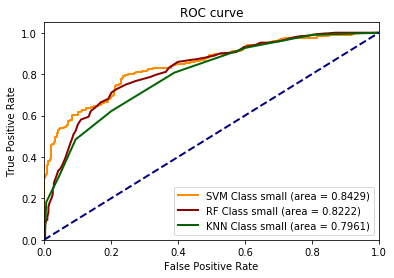

<Figure size 432x288 with 0 Axes>

In [150]:
plot_roc_3_classes(0, Result_fprtpr)
plt.savefig('for small class.jpg')

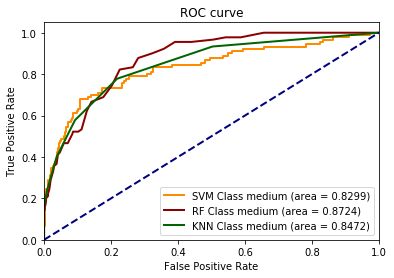

<Figure size 432x288 with 0 Axes>

In [151]:
plot_roc_3_classes(1, Result_fprtpr)
plt.savefig('for medium class.jpg')

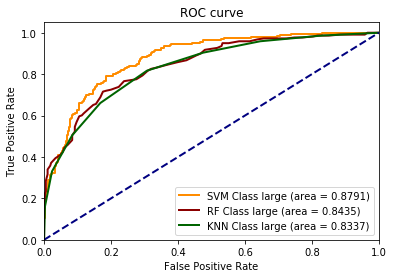

<Figure size 432x288 with 0 Axes>

In [152]:
plot_roc_3_classes(2, Result_fprtpr)
plt.savefig('for large class.jpg')

## AgglomerativeClustering

In [134]:
uniq_labels = np.unique(cropped_label)
Cropped_each_rand_set = []
Cropped_each_rand_set2 = []
Cropped_each_rand_set_label = []
chosen = []
for i in uniq_labels:
    index_choice = np.where(np.array(cropped_label) == i)[0]
    choosen_index = np.random.choice(index_choice, 1, replace = False)
    for k in range(len(choosen_index)):
        Cropped_each_rand_set += [cropped[choosen_index[k]]] # original pixels
        Cropped_each_rand_set2 += [X[choosen_index[k]], ] # 128
        Cropped_each_rand_set_label += [cropped_label[choosen_index[k]]]
        chosen += [choosen_index[k]]
len(Cropped_each_rand_set), len(Cropped_each_rand_set_label), len(chosen)

(62, 62, 62)

In [137]:
num_clu = 3
#m = KMeans(n_clusters = num_clu, random_state=0)
m = AgglomerativeClustering(n_clusters = num_clu)
#m.fit(X)
X2 = Cropped_each_rand_set2
m.fit(X2)
#predict_cluster = m.predict(X)
predict_cluster = m.labels_

In [138]:
cluster = [np.array(chosen)[predict_cluster == i] for i in range(num_clu)]
X_subsets = []
y_subsets = []
for i in range(num_clu):    
    X_inside = []
    label_inside = []
    for j in cluster[i]:
        X_inside += [cropped[j]]
        label_inside += [cropped_label[j]]
    X_subsets += [X_inside]
    y_subsets += [label_inside]

In [139]:
num_in_each_cluster = [len(X_subsets[i]) for i in range(num_clu)]
sum(num_in_each_cluster), num_in_each_cluster

(62, [34, 22, 6])

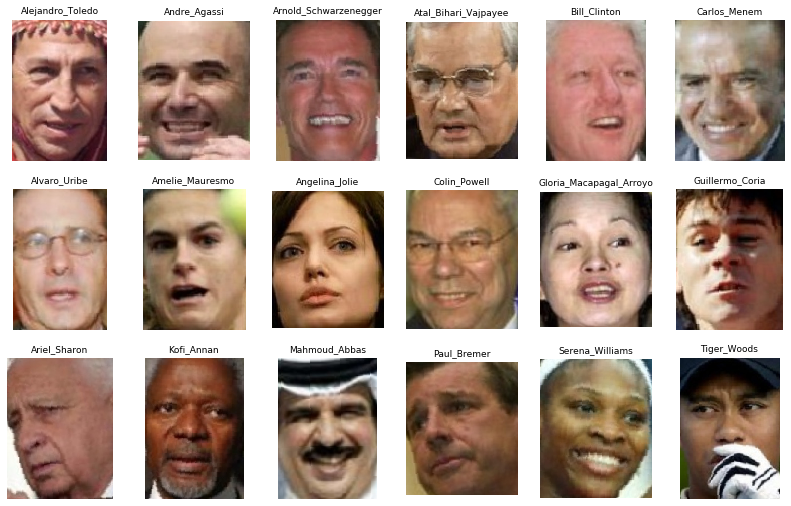

In [140]:
r = num_clu
c = min(num_in_each_cluster) if min(num_in_each_cluster) < 10 else 10
fig = plt.figure(figsize=(14, 14))
#fig.tight_layout()
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

num_sub_plots = 0
for i in range(r):
    total_col = len(X_subsets[i]) if len(X_subsets[i]) < c else c
    for j in range(total_col):
        img = X_subsets[i][j]
        num_sub_plots += 1
        ax = fig.add_subplot(r, c, num_sub_plots)
        ax.set_title(y_subsets[i][j], fontdict = {'fontsize': 9})
        plt.axis('off')
        plt.subplots_adjust(top = 0.6, right = 0.9)
        plt.imshow(img)

#plt.xlabel('xlabel', fontsize=18)
plt.show()